## INM 702 Coursework Code: Task 5
## Implementation of a fully connected Neural Network from scratch on CK+ dataset
### By: Jasveen Kaur and Nikhil Vallakati


### Importing packages

In [102]:
from __future__ import print_function, division
from builtins import range
import numpy as np
from scipy.special import expit
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import os
import scipy.stats as stats
import time
import pandas as pd
from keras.utils import np_utils

### Data Loading and Preprocessing

In [103]:
data = pd.read_pickle('./ck_final.pickle')

In [104]:
(training_data, validation_data, test_data) = data['training_data'], data['validation_data'], data['test_data']
(X_train, y_train), (X_val, y_val), (X_test, y_test) = (training_data[0],training_data[1]), (validation_data[0],validation_data[1]), (test_data[0],test_data[1])

# input image dimensions
img_rows, img_cols = data['img_dim']['width'], data['img_dim']['height']

In [105]:
#Checking the dimensions of the raw datasets
print("Train set images:", X_train.shape)
print("Train set labels:", y_train.shape)
print("Validation set images:", X_val.shape)
print("Train set labels:", y_val.shape)
print("Test set images:", X_test.shape)
print("Train set labels:", y_test.shape)

Train set images: (4117, 10000)
Train set labels: (4117, 1)
Validation set images: (874, 10000)
Train set labels: (874, 1)
Test set images: (885, 10000)
Train set labels: (885, 1)


In [106]:
# Converting the labels to their categorical form (similar to one-hot encoding)
num_labels = 8
Y_train = np_utils.to_categorical(y_train, num_labels)
Y_val = np_utils.to_categorical(y_val, num_labels)
Y_test = np_utils.to_categorical(y_test, num_labels)

In [107]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [108]:
#Dimensions of the reshaped dataset
print("Train set images:", X_train.shape)
print("Train set labels:", Y_train.shape)
print("Validation set images:", X_val.shape)
print("Train set labels:", Y_val.shape)
print("Test set images:", X_test.shape)
print("Train set labels:", Y_test.shape)

Train set images: (4117, 100, 100, 1)
Train set labels: (4117, 8)
Validation set images: (874, 100, 100, 1)
Train set labels: (874, 8)
Test set images: (885, 100, 100, 1)
Train set labels: (885, 8)


### Plotting the sample images

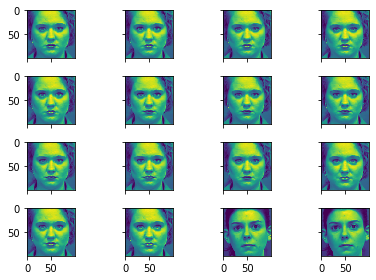

In [109]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(16): 
    ax[i].imshow(X_train[i].reshape(100,100))
plt.tight_layout()
plt.show()

### Normalizing and Reshaping the images

In [144]:
fact = 0.99/255
X_train = X_train.flatten().reshape(4117, 10000)*fact + 0.01
X_test = X_test.flatten().reshape(885, 10000)*fact + 0.01
X_val = X_val.flatten().reshape(874, 10000)*fact + 0.01
print(X_train.shape, X_test.shape, X_val.shape)

(4117, 10000) (885, 10000) (874, 10000)


In [113]:
np.savez_compressed('ck_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_val = X_val,
                    y_val = y_val,
                    X_test=X_test,
                    y_test=y_test)

ck = np.load('ck_scaled.npz')
ck.files

X_train, y_train, X_test, y_test, X_val, y_val = [ck[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test', 'X_val', 'y_val' ]]

### Neural Network

In [131]:
class neural_network(object):

    def __init__(self, n_hidden1,n_hidden2, n_hidden3, n_hidden4, l2, epochs, lr,
                 shuffle, minibatch_size, seed, reg, drop):

        self.random = np.random.RandomState(seed)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2 
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.reg = reg
        self.drop = drop
      
    def one_hot_encode(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    #relu activation function
    def relu(self, x):
        return np.maximum(0, x) 
    
    #derivative of relu activation function(element)
    def relu_d_element(self, x):
        if x > 0:
            return 1
        elif x <= 0:
            return 0
    
    #derivative of relu activation function(array)
    def relu_d_array(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    #sigmoid activation function
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-np.clip(x, -250, 250)))
    
    #Inverted dropout function definition
    def inverted_drop(self, p, x):
        idropout_mask = (np.random.rand(*x.shape) < p) / p #dropout mask. Notice /p!
        x *= idropout_mask
        return x
     
    #leaky relu activation function
    def lrelu(self, x):
        alpha = 0.01
        return np.maximum(alpha*x, x) 
    
    #derivative of leaky relu
    def lrelu_d(self, x):
        alpha = 0.01
        relu_d = np.where(x <= 0, alpha, 1.0) 
        return relu_d
        
    #softmax function definition   
    def softmax_basic(self, x):
        exp_scores = np.exp(x)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    #softmax to calculate gradient
    def softmax_grad(self, s): 
        #a = np.diag(np.diag(s))
        S_vector = np.diag(s)
        S_matrix = np.transpose(S_vector)
        return np.diag(s) - (S_matrix * np.transpose(S_matrix))
    
    #forward pass
    def forward_pass(self, X):
      
        z1 = np.dot(X, self.w1) + self.b1
        a1 = self.lrelu(z1)
        
        if self.drop:
            a1 = self.inverted_drop(0.8, a1)
        
        z2 = np.dot(a1, self.w2) + self.b2
        a2 = self.lrelu(z2)
        
        if self.drop:
            a2 = self.inverted_drop(0.8, a2)
        
        z3 = np.dot(a2, self.w3) +self.b3
        a3 = self.lrelu(z3)
        
        if self.drop:
            a3 = self.inverted_drop(0.8, a3)
        
        z4 = np.dot(a3, self.w4) +self.b4
        a4 = self.lrelu(z4)
        
        if self.drop:
            a4 = self.inverted_drop(0.8, a4)
        
        z_out = np.dot(a4, self.w_out) + self.b_out
        a_out = self.softmax_basic(z_out)

        return z1, a1, z2, a2, z3, a3, z4, a4, z_out, a_out


    #Computing the loss term with additional L2 regularizer
    def compute_cost(self, y_enc, a_out):

        y_enc = y_enc.argmax(axis=1)
        m = y_enc.shape[0]
        log_probs = -np.log(a_out[range(m),y_enc])
        loss = np.sum(log_probs) / m
        
        #regularization term
        if self.reg:
            reg_loss = 0.5*self.l2*np.sum(self.w1*self.w1) + 0.5*self.l2*np.sum(self.w2*self.w2)+ 0.5*self.l2*np.sum(self.w3*self.w3) + 0.5*self.l2*np.sum(self.w_out*self.w_out)
            loss += reg_loss
            
        return loss
    
    #predicting the output
    def predict_out(self, X):
        z1, a1, z2, a2, z3, a3, z4, a4, z_out, a_out = self.forward_pass(X)
        y_pred = np.argmax(a_out, axis=1)
        return y_pred
    
    #Calculating the accuracy
    def accuracy(self, y, y_pred, X):
        return ((np.sum(y.T == y_pred)).astype(np.float) /
                         X.shape[0])
    
    #Training the network
    def train(self, X_train, y_train, X_valid, y_valid):

        
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
    
        #initializing the weights
        
        #hidden layer 1
        self.b1 = np.zeros(self.n_hidden1)
        self.w1 = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden1))
        
        #hidden layer 2
        self.b2 = np.zeros(self.n_hidden2)
        self.w2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden1, self.n_hidden2))
        
        #hidden layer 3
        self.b3 = np.zeros(self.n_hidden3)
        self.w3 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, self.n_hidden3))
        
        #hidden layer 4
        self.b4 = np.zeros(self.n_hidden4)
        self.w4 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden3, self.n_hidden4))
        
        #output layer
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden4, n_output))
        
        #defining a dictionary to save the results
        self.results = {'cost': [], 'train_acc': [], 'valid_acc': []}        
        start_time = time.time()
        
        #encoding the labels
        y_train_enc = self.one_hot_encode(y_train, n_output)

        #training epochs
        for i in range(self.epochs):

            #minibatches
            samples = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(samples)

            for start_idx in range(0, samples.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = samples[start_idx:start_idx + self.minibatch_size]

                
                # forward propagation
             
                z1, a1, z2, a2, z3, a3, z4, a4,  z_out, a_out = self.forward_pass(X_train[batch_idx])
                #cost = self.compute_cost(y_train_enc[batch_idx], a_out)
                
                # Backpropagation
                sigma_out = a_out - y_train_enc[batch_idx]
                relu_derivative4 = self.lrelu_d(a4)
                sigma_h4 = (np.dot(sigma_out, self.w_out.T) * relu_derivative4)
                
                relu_derivative3 = self.lrelu_d(a3)
                sigma_h3 = (np.dot(sigma_h4, self.w4.T) * relu_derivative3)
                
                relu_derivative2 = self.lrelu_d(a2)
                sigma_h2 = (np.dot(sigma_h3, self.w3.T) * relu_derivative2)
                
                relu_derivative1 = self.lrelu_d(a1)
                sigma_h1 = (np.dot(sigma_h2, self.w2.T) * relu_derivative1)
                
                grad_w4 = np.dot(a3.T, sigma_h4)
                grad_w3 = np.dot(a2.T, sigma_h3)
                grad_w2 = np.dot(a1.T, sigma_h2)
                grad_w1 = np.dot(X_train[batch_idx].T, sigma_h1)
                grad_w_out = np.dot(a4.T, sigma_out)
                
                grad_b4 = np.sum(sigma_h4, axis=0)
                grad_b3 = np.sum(sigma_h3, axis=0)
                grad_b2 = np.sum(sigma_h2, axis=0)
                grad_b1 = np.sum(sigma_h1, axis=0)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                delta_w4 = (grad_w4 + self.l2*self.w4)
                delta_w3 = (grad_w3 + self.l2*self.w3)
                delta_w2 = (grad_w2 + self.l2*self.w2)
                delta_w1 = (grad_w1 + self.l2*self.w1)
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                #delta_w4 = grad_w4
                #delta_w3 = grad_w3 
                #delta_w2 = grad_w2 
                #delta_w1 = grad_w1 
                #delta_w_out = grad_w_out

                delta_b4 = grad_b4
                delta_b3 = grad_b3
                delta_b2 = grad_b2 
                delta_b1 = grad_b1
                delta_b_out = grad_b_out
                
                self.w4 -= self.lr * delta_w4
                self.w3 -= self.lr * delta_w3
                self.w2 -= self.lr * delta_w2
                self.w1 -= self.lr * delta_w1
                self.w_out -= self.lr * delta_w_out
                
                self.b4 -= self.lr * delta_b4
                self.b3 -= self.lr * delta_b3
                self.b2 -= self.lr * delta_b2
                self.b1 -= self.lr * delta_b1           
                self.b_out -= self.lr * delta_b_out

        
            #evaluating the trained model with updated weights
            z1, a1, z2, a2, z3, a3, z4, a4, z_out, a_out = self.forward_pass(X_train)            
            
            cost = self.compute_cost(y_enc=y_train_enc, a_out=a_out)
            
            y_train_pred = self.predict_out(X_train)
            y_valid_pred = self.predict_out(X_valid)

            train_acc = self.accuracy(y_train, y_train_pred, X_train)
            valid_acc = self.accuracy(y_valid, y_valid_pred, X_valid)
            
            print("epoch:", i+1)
            
            print("Train Accuracy:","{:.2f}".format(train_acc*100),"% ||","Valid. Accuracy:","{:.2f}".format(valid_acc*100),"% ||","loss:","{:.3f}".format(cost))
            print("Training time: {}".format(time.strftime("%Mm %Ss", time.gmtime(time.time()-start_time))))
            
            self.results['cost'].append(cost)
            self.results['train_acc'].append(train_acc)
            self.results['valid_acc'].append(valid_acc)

        return self


In [136]:
Model = neural_network(n_hidden1=784,n_hidden2=512, n_hidden3 = 128, n_hidden4 = 64,
                  l2=0.0001, 
                  epochs=20, 
                  lr=0.0001,
                  minibatch_size=64, 
                  shuffle=True,
                  seed=1,
                  reg = True,
                  drop = True)

In [137]:
Model.train(X_train=X_train, 
       y_train=y_train,
       X_valid=X_val,
       y_valid=y_val)

epoch: 1
Train Accuracy: 17.80 % || Valid. Accuracy: 18.19 % || loss: 6.190
Training time: 00m 44s
epoch: 2
Train Accuracy: 24.44 % || Valid. Accuracy: 22.54 % || loss: 6.138
Training time: 01m 32s
epoch: 3
Train Accuracy: 24.80 % || Valid. Accuracy: 25.74 % || loss: 6.118
Training time: 02m 18s
epoch: 4
Train Accuracy: 24.70 % || Valid. Accuracy: 24.37 % || loss: 6.112
Training time: 03m 08s
epoch: 5
Train Accuracy: 24.61 % || Valid. Accuracy: 25.74 % || loss: 6.106
Training time: 03m 53s
epoch: 6
Train Accuracy: 25.07 % || Valid. Accuracy: 24.14 % || loss: 6.102
Training time: 04m 41s
epoch: 7
Train Accuracy: 24.90 % || Valid. Accuracy: 25.51 % || loss: 6.101
Training time: 05m 27s
epoch: 8
Train Accuracy: 25.41 % || Valid. Accuracy: 25.63 % || loss: 6.100
Training time: 06m 15s
epoch: 9
Train Accuracy: 24.92 % || Valid. Accuracy: 25.86 % || loss: 6.101
Training time: 07m 02s
epoch: 10
Train Accuracy: 25.55 % || Valid. Accuracy: 24.94 % || loss: 6.096
Training time: 07m 49s
epoch: 11

### Graph for the Loss Function

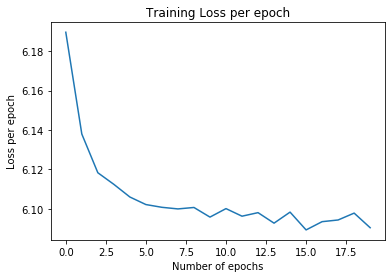

In [138]:
plt.plot(range(Model.epochs), Model.results['cost'])
plt.ylabel('Loss per epoch')
plt.xlabel('Number of epochs')
plt.title('Training Loss per epoch')
plt.show()

### Accuracy Graph

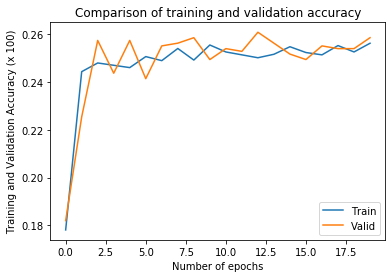

In [142]:
plt.plot(Model.results['train_acc'], 
         label='Train')
plt.plot(Model.results['valid_acc'], 
         label='Valid')
plt.ylabel('Training and Validation Accuracy (x 100)')
plt.xlabel('Number of epochs')
plt.legend()
plt.title('Comparison of training and validation accuracy')
plt.show()